### Imports

In [314]:
import struct

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import mlab
from scipy.constants import pi, c
from scipy.fft import fft, ifft, fftshift, ifftshift, ifft2, fft2

from decoding import get_header_dict, packet_generator_from_file, packet_generator, build_data_word_dict, index_decoder, annotation_decoder
from packet import Packet
from utils import create_bit_string, find_packet_of_type, time_packet_generation
from structs import SUB_COMM_KEY_POS, SUB_COMM_KEY_VAL, WORD_SIZE, F_REF

### Plotting Functions

In [2]:
def plot_signal(signal, title=""):
    fig = plt.figure()
    fig.set_size_inches(12, 2)
    plt.plot(signal)
    plt.title(title)

def plot_signal_components(signal, start_time, end_time, scale=(None, None), fft_size=128, sample_rate=3*1e+8, title="", size=(6, 12)):
    t = np.linspace(start_time, end_time, signal.shape[0])
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(size[1], size[0]))
    ax1.plot(t, signal.imag, linewidth=0.75, label='Imaginary Part', color="red")
    ax1.plot(t, signal.real, linewidth=0.75, label='Real Part', color="darkblue")
    ax1.set_title(title)
    ax1.set_xlabel("Time (us)")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="lower right")
    ax1.grid(True)
    ax1.set_xlim([t[0], t[-1]])
    ax2.plot(t, np.unwrap(np.angle(signal)), linewidth=0.75, color="red")
    ax2.set_xlabel("Time (us)")
    ax2.set_ylabel("Phase")
    ax2.grid(True)
    ax2.set_xlim([t[0], t[-1]])
    if scale is not None:
        ax3.specgram(signal, NFFT=fft_size, Fs=sample_rate, noverlap=fft_size-1, cmap='seismic', vmin=scale[0], vmax=scale[1], window=mlab.window_hanning)
    else:
        ax3.specgram(signal, NFFT=fft_size, Fs=sample_rate, noverlap=fft_size-1, cmap='seismic')
    ax3.set_xlabel("Time (us)")
    ax3.set_ylabel("Frequency")
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)
    plt.show()

def norm_log(signal, weight=20):
    norm = np.abs(signal) / np.max(np.abs(signal))
    return weight * np.log10(norm)

### Saving Function

In [3]:
def save_to_cf32(data: np.ndarray, filename: str):
    if not np.iscomplexobj(data):
        raise ValueError("Input data must be a complex numpy array.")
    interleaved_data = np.empty(2 * len(data), dtype=np.float32)
    interleaved_data[0::2] = data.real.astype(np.float32)
    interleaved_data[1::2] = data.imag.astype(np.float32)
    interleaved_data.tofile(filename)

### Processing Functions

In [4]:
range_decimation_list = [
    112.6041667, 100.0925926, 0.000000000, 83.41049387,
    66.72839509, 56.30208336, 50.04629632, 25.02314816,
    64.34523813, 46.91840280, 17.32371796, 54.59595962
]

def get_replica_chirp(packet):
    secondary_header = packet.get_secondary_header()
    range_decimation = secondary_header['range_decimation']
    txpsf = secondary_header['tx_pulse_start_frequency']
    txprr = secondary_header['tx_ramp_rate']
    txpl  = secondary_header['pulse_length']
    phi_1 = txpsf
    phi_2 = txprr / 2
    fs = int(np.floor(range_decimation_list[range_decimation] * txpl))
    t = np.linspace(0.0, txpl, fs)
    chirp = (1 / fs) * np.exp(2 * pi * 1j * (phi_1 * t + phi_2 * (t**2)))
    return chirp

def pulse_compression(chirp, replica):
    num_range_samples = chirp.shape[0]
    num_rep_samples = replica.shape[0]
    fft_pad_amount = int(2**np.ceil(np.log2(num_range_samples)) - num_range_samples)
    chirp_padded = np.pad(chirp, (0, fft_pad_amount))
    f_chirp = fft(chirp_padded)
    length = num_range_samples + fft_pad_amount
    num_rep_samples = replica.shape[0]
    rep_pad_amount = (num_range_samples - num_rep_samples) + fft_pad_amount
    f_ref_func = np.conj(fft(np.pad(replica, (0, rep_pad_amount))))
    pulse_compressed = ifft(f_chirp * f_ref_func)
    pulse_compressed = np.roll(pulse_compressed, num_rep_samples//2)
    return pulse_compressed[0:num_range_samples]

def get_nth_packet(filename, n):
    raw_data = open(filename, 'rb')
    PacketGenerator = packet_generator(raw_data)
    packet = None
    index = 0
    while index <= n:
        packet = next(PacketGenerator)
        index += 1
    return packet

### Get Signals

In [5]:
filename = '/Users/asplayer/repos/sentinel1_decode/data/points/point.dat'
packet = get_nth_packet(filename, 500)
signal = packet.get_complex_samples()[0]
replica = get_replica_chirp(packet)
pulse_compressed = pulse_compression(signal, replica)
cross_correlated = np.correlate(signal, replica, "same")

### Save Signals

In [6]:
save_to_cf32(signal, 'signal.cf32')
save_to_cf32(replica, 'replica.cf32')
save_to_cf32(pulse_compressed, 'pulse_compressed.cf32')
save_to_cf32(cross_correlated, 'cross_correlated.cf32')

### Plot Signals

In [7]:
pop_out_plots = False
if pop_out_plots:
    %matplotlib qt
else:
    %matplotlib inline

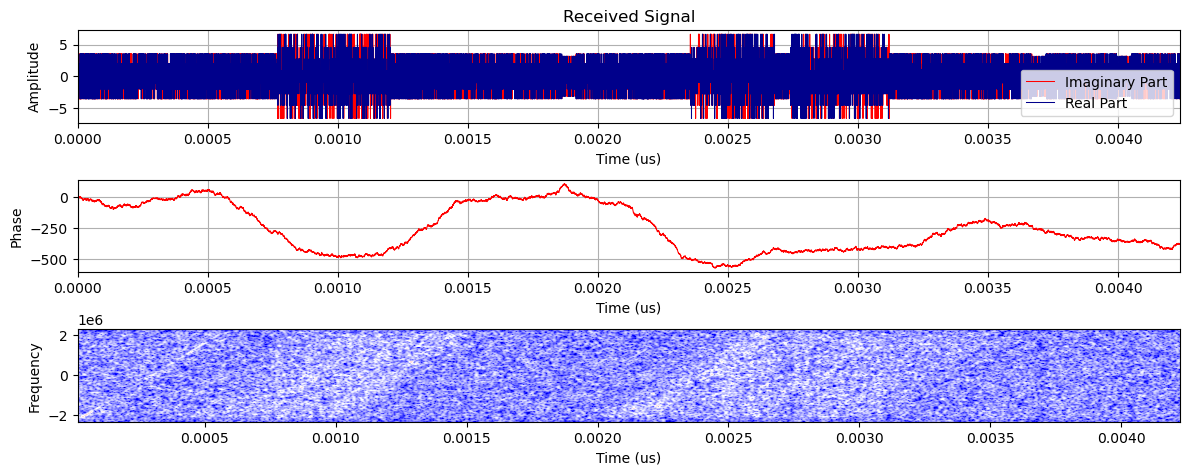

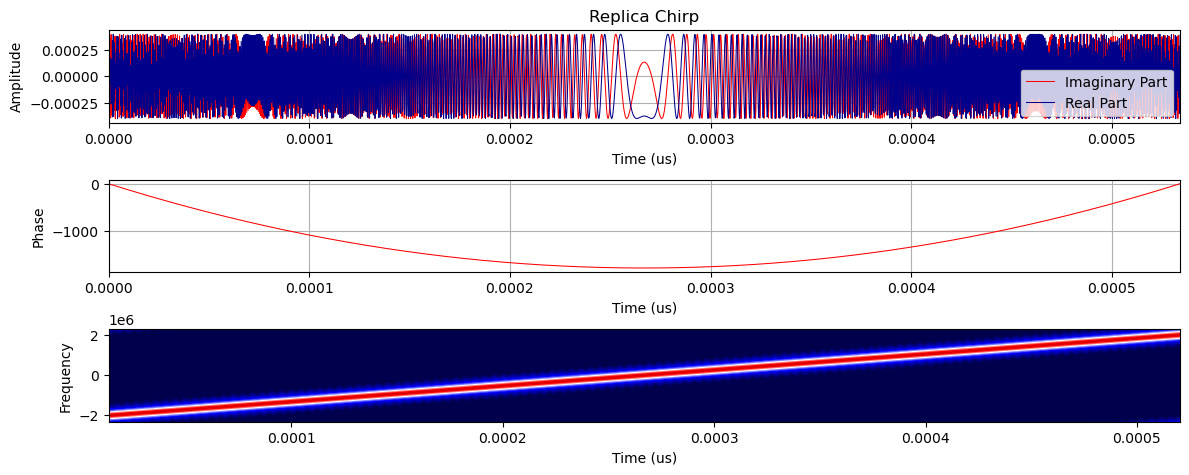

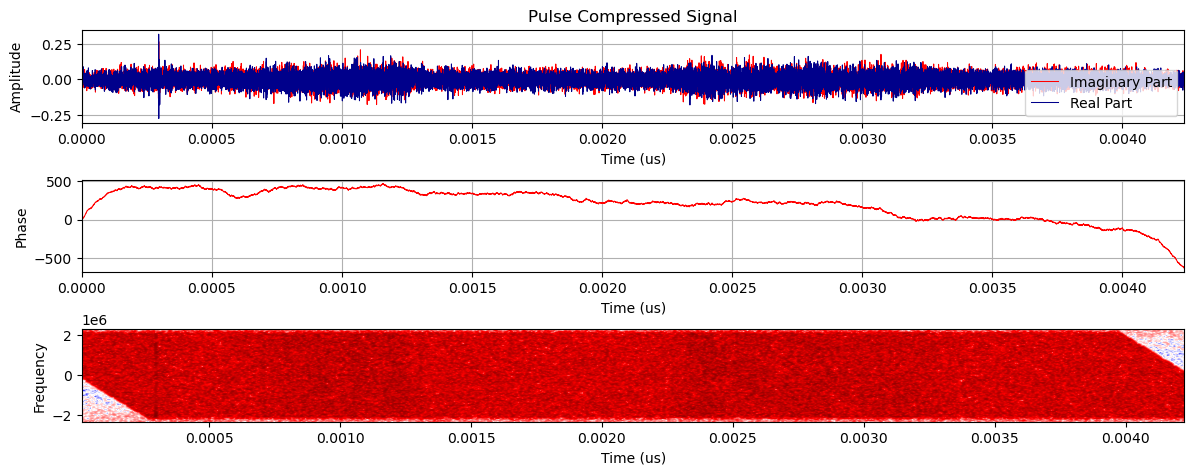

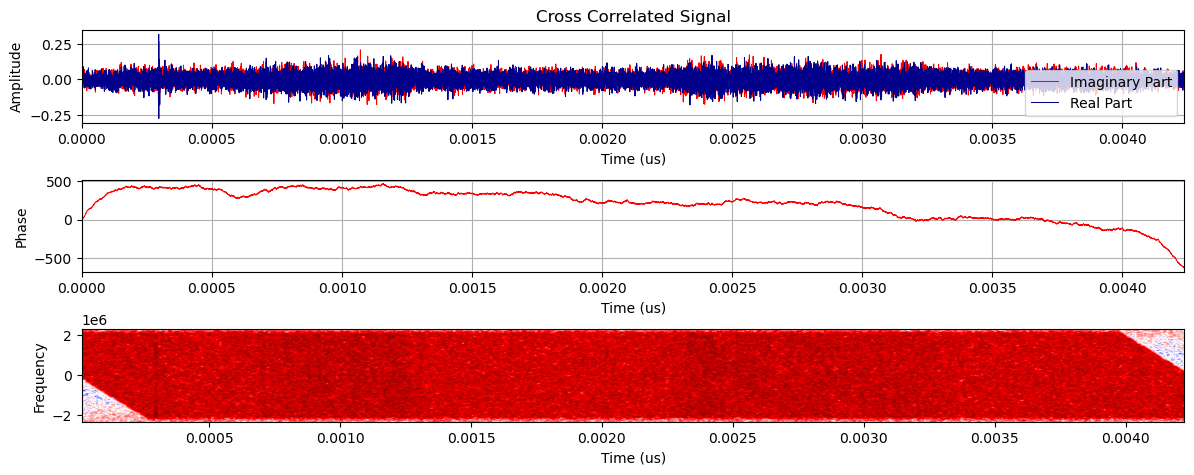

In [8]:
packet_header = packet.get_secondary_header()
sampling_window_length = packet_header["swl"] * 10e-6
txpl = packet_header["pulse_length"]
pulse_length = txpl * 10e-6
range_decimation = packet_header["range_decimation"]
delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
start_time = packet_header["swst"] * 1e-6
pri = packet_header["pri"] * 1e-6
rank = packet_header["rank"]
delay = rank * pri + start_time + delta_t_suppressed
fft_size = 128
sample_rate = signal.shape[0] / sampling_window_length

plot_signal_components(signal, 0, sampling_window_length, scale=(-100, 0), fft_size=fft_size, sample_rate=sample_rate, title="Received Signal")
plot_signal_components(replica, 0, pulse_length, scale=(-200, -100), fft_size=fft_size, sample_rate=(replica.shape[0]/pulse_length), title="Replica Chirp")
plot_signal_components(pulse_compressed, 0, sampling_window_length, fft_size=fft_size, sample_rate=sample_rate, title="Pulse Compressed Signal")
plot_signal_components(cross_correlated, 0, sampling_window_length, fft_size=fft_size, sample_rate=cross_correlated.shape[0]/sampling_window_length, title="Cross Correlated Signal")

### Time Delay and Range to Target

In [9]:
compressed_abs = np.abs(pulse_compressed)
t = np.linspace(delay, delay + sampling_window_length, signal.shape[0])
threshold = 1.5 * 1e9
for i in range(compressed_abs.shape[0]):
    val = compressed_abs[i]
    if val > threshold:
        print (f"Target Time Delay: {t[i]} seconds")
        print (f"Target Distance: {t[i]*c/2} meters")
        break
start_range = (delay * c) / 2
end_range = (delay + sampling_window_length) * c / 2
print (f"Window Start Range: {start_range} meters")
print (f"Window End Range: {end_range} meters")

Window Start Range: 901680.312121713 meters
Window End Range: 1536971.8684798507 meters


### Working with a Burst

#### Retrieve Packets and Load Signals

In [12]:
def get_packets_in_swath(data, swath_num):
    PacketGenerator = packet_generator(data)
    swath_packets = []
    packet_index = 0
    while (data):
        try:
            packet = next(PacketGenerator)
            if packet.data_format() == 'D':
                if packet.get_secondary_header()['swath_number'] == swath_num:
                    swath_packets.append((packet, packet_index))
            packet_index += 1
        except ValueError as ve:
            break
    return swath_packets

def get_packets_in_bursts(swath_packets):
    bursts = []
    burst_packets = []
    previous_az = 0
    index = 0
    for packet, packet_index in swath_packets:
        az = packet.get_secondary_header()['azimuth_beam_address']
        if index == 0:
            previous_az = az
        if az != previous_az and az != previous_az + 1:
            bursts.append(burst_packets)
            burst_packets = []
        burst_packets.append((packet, packet_index))
        previous_az = az
        if index == len(swath_packets) - 1:
            bursts.append(burst_packets)
        index += 1
    return bursts

def get_packets_in_burst(swath_packets, burst_num):
    bursts = get_packets_in_bursts(swath_packets)
    return bursts[burst_num]

def plot_signals(signals, title="", xlabel="", ylabel="", aspect="auto"):
    fig = plt.figure()
    fig.set_size_inches(12, 3)
    plt.imshow(signals, cmap='jet', aspect=aspect, origin="lower")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [505]:
data = open(filename, 'rb')
swath_packets = get_packets_in_swath(data, 11)
burst_packet_pairs = get_packets_in_burst(swath_packets, 10)
burst_packets = [packet for packet, _ in burst_packet_pairs]
packet_indecies = [index for _, index in burst_packet_pairs]
signals = np.load("/Users/asplayer/data/L0_npz/points_iw2_10.npy")

### Range Compression

#### Range Compression with Pulse Compression

In [506]:
def get_replica_chirps(packets):
    replica_chirps = []
    for packet in packets:
        secondary_header = packet.get_secondary_header()
        range_decimation = secondary_header['range_decimation']
        txpsf = secondary_header['tx_pulse_start_frequency']
        txprr = secondary_header['tx_ramp_rate']
        txpl  = secondary_header['pulse_length']
        phi_1 = txpsf
        phi_2 = txprr / 2
        fs = int(np.floor(range_decimation_list[range_decimation] * txpl))
        t = np.linspace(0.0, txpl, fs)
        chirp = (1 / fs) * np.exp(2 * pi * 1j * (phi_1 * t + phi_2 * (t**2)))
        replica_chirps.append(chirp)
    return np.asarray(replica_chirps)

def range_compress_burst(signals, replica_chirps):
    num_packets = signals.shape[0]
    range_compressed_signals = []
    for i in range(num_packets):
        range_compressed_signals.append(pulse_compression(signals[i], replica_chirps[i]))
    return np.asarray(range_compressed_signals)

In [507]:
replica_chirps = get_replica_chirps(burst_packets)
range_compressed_burst = range_compress_burst(signals, replica_chirps)
range_compressed_burst_norm = np.abs(range_compressed_burst) / np.max(np.abs(range_compressed_burst))

#### Plotting

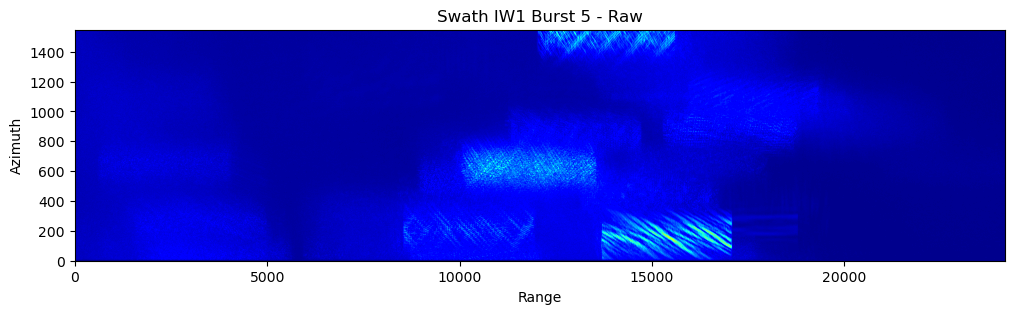

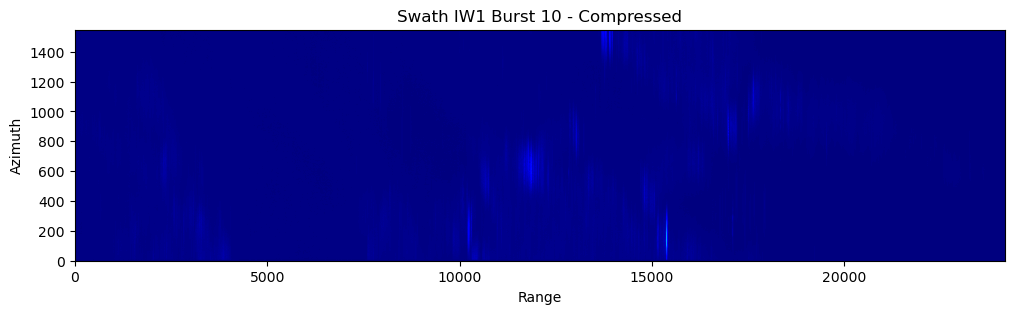

In [508]:
plot_signals(np.abs(signals) / np.max(np.abs(signals)), title="Swath IW1 Burst 5 - Raw", xlabel="Range", ylabel="Azimuth")
plot_signals(range_compressed_burst_norm, title="Swath IW1 Burst 10 - Compressed", xlabel="Range", ylabel="Azimuth")

### Range Doppler Space

In [509]:
num_az_samples = range_compressed_burst.shape[0]
num_az_fft_samples = int(2**np.ceil(np.log2(num_az_samples)))
fft_pad_amount = num_az_fft_samples - num_az_samples
range_compressed_burst_padded = np.pad(range_compressed_burst, ((0, fft_pad_amount), (0, 0)), mode='constant')

In [510]:
range_doppler_compressed_burst = fft(range_compressed_burst, axis=0)
range_doppler_compressed_burst_norm = np.abs(range_doppler_compressed_burst) / np.max(np.abs(range_doppler_compressed_burst))

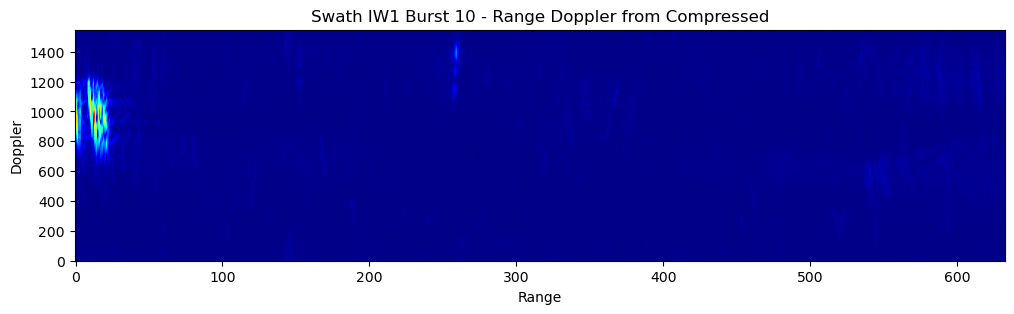

In [511]:
desired_signal = 15367
plot_signals(range_doppler_compressed_burst_norm[:, desired_signal:16000], title="Swath IW1 Burst 10 - Range Doppler from Compressed", xlabel="Range", ylabel="Doppler")

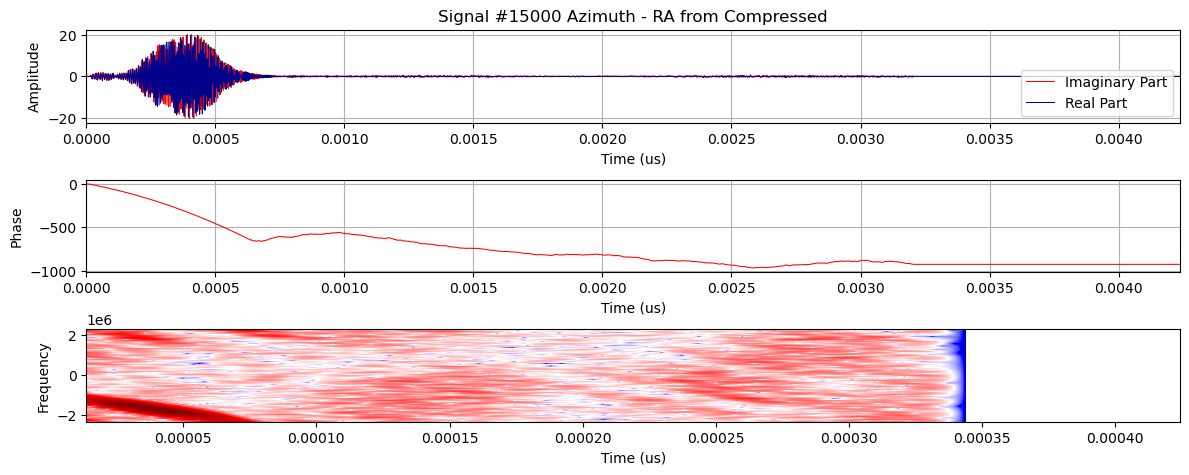

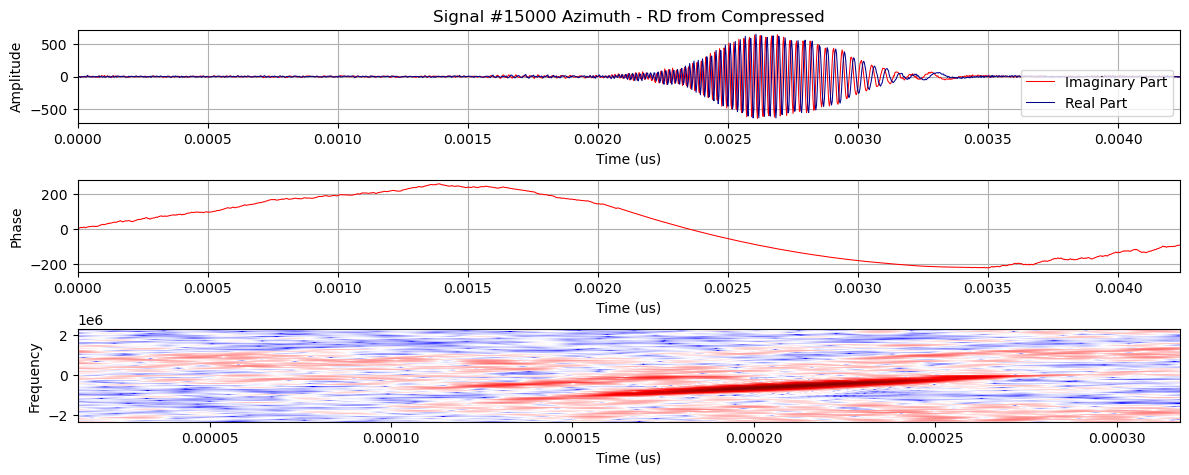

In [513]:
ra_azimuth_signal_compressed = range_compressed_burst_padded[:, desired_signal]
rd_azimuth_signal_compressed = range_doppler_compressed_burst[:, desired_signal]
plot_signal_components(ra_azimuth_signal_compressed, 0, sampling_window_length, fft_size=fft_size, sample_rate=sample_rate, title="Signal #15000 Azimuth - RA from Compressed")
plot_signal_components(rd_azimuth_signal_compressed, 0, sampling_window_length, fft_size=fft_size, sample_rate=sample_rate, title="Signal #15000 Azimuth - RD from Compressed")

### Azimuth Compression with Point Target

In [514]:
range_azimuth_compressed = ifft(ifftshift(range_doppler_compressed_burst, 0), axis=0)

num_az_samples = range_compressed_burst.shape[0]
num_rng_samples = range_azimuth_compressed.shape[1]

chirp_compressed = np.conj(np.flip(range_doppler_compressed_burst[:, desired_signal]))
azimuth_compressed_compressed = np.zeros_like(range_doppler_compressed_burst)

for i in range(num_rng_samples):
    azimuth_compressed_compressed[:, i] = ifft(fftshift(fft(range_azimuth_compressed[:, i])) * chirp_compressed)

# azimuth_compressed_compressed = np.roll(azimuth_compressed_compressed, num_az_samples//2, 0)
azimuth_compressed_compressed_norm = np.abs(azimuth_compressed_compressed) / np.max(np.abs(azimuth_compressed_compressed))

Text(0.5, 1.0, 'Azimuth Compressed Burst')

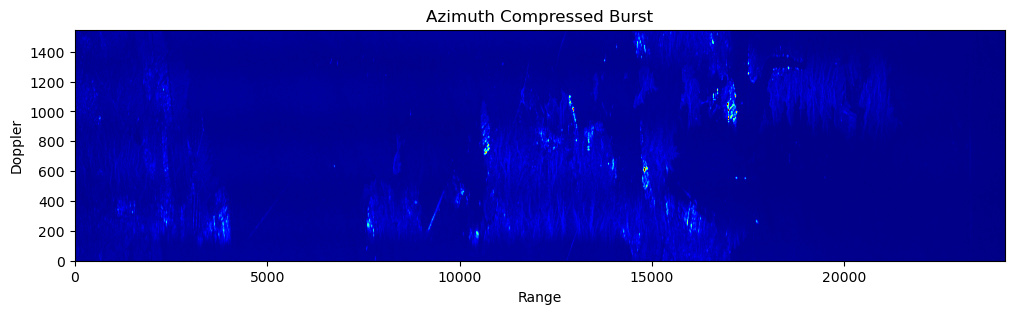

In [515]:
fig = plt.figure()
fig.set_size_inches(12, 3)
plt.imshow(azimuth_compressed_compressed_norm, cmap='jet', aspect="auto", origin="lower", vmin=0, vmax=0.1)
plt.xlabel("Range")
plt.ylabel("Doppler")
plt.title("Azimuth Compressed Burst")

In [516]:
# from PIL import Image
# im = Image.fromarray(azimuth_compressed_compressed_norm)
# im.save("azimuth_compressed_points_IW2_10.tif")

### Get $V_r$, $k_s$, etc...

In [517]:
from datetime import datetime, timedelta, timezone

from scipy.spatial.transform import Rotation
from scipy.interpolate import interp1d

def get_all_data_packets_from_file(filename):
    packets = []
    indexes = []
    index = 0
    with open(filename, 'rb') as data:
        PacketGenerator = packet_generator(data)
        while (data):
            try:
                packet = next(PacketGenerator)
                packets.append(packet)
                indexes.append(index)
                index += 1
            except ValueError as ve:
                break
    return packets, indexes

def mjd2000_time_to_datetime(gps_time_seconds):
    mjd2000_epoch = datetime(2000, 1, 1, tzinfo=timezone(timedelta(0)))
    current_time = gps_epoch + timedelta(seconds=gps_time_seconds)

def gps_time_to_datetime(gps_time_seconds):
    # GPS epoch is January 6, 1980, 00:00:00 UTC
    gps_epoch = datetime(1980, 1, 6, tzinfo=timezone(timedelta(0)))
    current_time = gps_epoch + timedelta(seconds=gps_time_seconds)
    return current_time
    
def gps_time_to_seconds_since_midnight(gps_time_seconds):
    # GPS epoch is January 6, 1980, 00:00:00 UTC
    gps_epoch = datetime(1980, 1, 6, tzinfo=timezone(timedelta(0)))
    whole_seconds = int(gps_time_seconds)
    fractional_seconds = gps_time_seconds - whole_seconds
    current_time = gps_epoch + timedelta(seconds=whole_seconds)
    seconds_since_midnight = (
        current_time.hour * 3600 +
        current_time.minute * 60 +
        current_time.second +
        fractional_seconds
    )
    return seconds_since_midnight

def data_word_time_stamp_to_seconds(time_stamp):
    time_stamp = time_stamp[8:64]
    num = 0
    for i in range(0, 32):
        num += int(time_stamp[i]) * (2 ** (32-i-1))
    for i in range(33, 56):
        num += int(time_stamp[i]) * (2 ** (-i))
    return num

def get_gps_time_from_packet(packet):
    header = packet.get_secondary_header()
    seconds = header['coarse_time']
    sub_seconds = 1 / header['fine_time']
    return gps_time_to_seconds_since_midnight(seconds + sub_seconds)

def annotation_time_to_datetime(days, milliseconds, microseconds):
    mj2000_epoch = datetime(2000, 1, 1, tzinfo=timezone(timedelta(0)))
    current_time = mj2000_epoch + timedelta(days=days, seconds=0, milliseconds=milliseconds, microseconds=microseconds)
    return current_time

def get_azimuth_time_from_record(record):
    days = record['days_ul']
    milliseconds = record['milliseconds_ul']
    microseconds = record['microseconds_ul']
    return annotation_time_to_datetime(days, milliseconds, microseconds)

def get_records(filename):
    filename_prefix = filename.split('.')[0]

    annotation_filename = filename_prefix + '_annot.dat'
    index_filename = filename_prefix + '_index.dat'
    
    with open(annotation_filename, 'rb') as annot_data:
        annotation_records = annotation_decoder(annot_data)
    with open(index_filename, 'rb') as index_data:
        index_records = index_decoder(index_data)
    return annotation_records, index_records

def to_float32(bit_string):
    int_representation = int(bit_string, 2)
    float_value = struct.unpack('f', struct.pack('I', int_representation))[0]
    return float_value

def to_float64(bit_string):
    int_representation = int(bit_string, 2)
    float_value = struct.unpack('d', struct.pack('Q', int_representation))[0]
    return float_value

def build_data_word_dict(packets, indexes, times):
    data_word_dicts = []
    sub_comm_dict = SUB_COMM_KEY_VAL.copy()
    initial_data_word_index = 0
    sc_data_word_index = 0
    for i in range(len(packets)):
        packet = packets[i]
        secondary_header = packet.get_secondary_header()
        sc_data_word_index = secondary_header['sc_data_word_index']
        if i == 0:
            initial_data_word_index = sc_data_word_index
        else:
            if sc_data_word_index == initial_data_word_index:
                sub_comm_dict['azimuth_time'] = times[indexes[i]]
                data_word_dicts.append(sub_comm_dict)
                sub_comm_dict = SUB_COMM_KEY_VAL.copy()
        data_word =  secondary_header['sc_data_word']
        key, pos = SUB_COMM_KEY_POS[sc_data_word_index]
        pos = pos * WORD_SIZE
        sub_comm_dict[key] = sub_comm_dict[key][0:pos] + data_word + sub_comm_dict[key][pos+WORD_SIZE:]
    if sc_data_word_index != initial_data_word_index:
        data_word_dicts.append(sub_comm_dict)
    for i in range(len(data_word_dicts)):
        data_word_dicts[i]['x_axis_position'] = to_float64(data_word_dicts[i]['x_axis_position'])
        data_word_dicts[i]['y_axis_position'] = to_float64(data_word_dicts[i]['y_axis_position'])
        data_word_dicts[i]['z_axis_position'] = to_float64(data_word_dicts[i]['z_axis_position'])
        data_word_dicts[i]['x_axis_velocity'] = to_float32(data_word_dicts[i]['x_axis_velocity'])
        data_word_dicts[i]['y_axis_velocity'] = to_float32(data_word_dicts[i]['y_axis_velocity'])
        data_word_dicts[i]['z_axis_velocity'] = to_float32(data_word_dicts[i]['z_axis_velocity'])
        data_word_dicts[i]['q0_quaternion']   = to_float32(data_word_dicts[i]['q0_quaternion'])
        data_word_dicts[i]['q1_quaternion']   = to_float32(data_word_dicts[i]['q1_quaternion'])
        data_word_dicts[i]['q2_quaternion']   = to_float32(data_word_dicts[i]['q2_quaternion'])
        data_word_dicts[i]['q3_quaternion']   = to_float32(data_word_dicts[i]['q3_quaternion'])
        data_word_dicts[i]['omega_x']         = to_float32(data_word_dicts[i]['omega_x'])
        data_word_dicts[i]['omega_y']         = to_float32(data_word_dicts[i]['omega_y'])
        data_word_dicts[i]['omega_z']         = to_float32(data_word_dicts[i]['omega_z'])
    return data_word_dicts

def get_times_from_subcomm_dicts(subcomm_dicts):
    times = []
    for subcomm_dict in subcomm_dicts[:-1]:
        gps_time = data_word_time_stamp_to_seconds(subcomm_dict["data_time_stamp"])
        data_time = gps_time_to_datetime(gps_time)
        times.append(data_time)
    return np.asarray(times)

def get_velocities_from_subcomm_dicts(subcomm_dicts):
    velocities = []
    for subcomm_dict in subcomm_dicts[:-1]:
        vx = subcomm_dict["x_axis_velocity"]
        vy = subcomm_dict["y_axis_velocity"]
        vz = subcomm_dict["z_axis_velocity"]
        velocities.append([vx, vy, vz])
    return np.asarray(velocities, dtype=np.float64)

def get_positions_from_subcomm_dicts(subcomm_dicts):
    positions = []
    for subcomm_dict in subcomm_dicts[:-1]:
        px = subcomm_dict["x_axis_position"]
        py = subcomm_dict["y_axis_position"]
        pz = subcomm_dict["z_axis_position"]
        positions.append([px, py, pz])
    return np.asarray(positions, dtype=np.float64)

def quaternion_to_rotation_matrix(q):
    """https://forum.step.esa.int/uploads/default/original/2X/3/315f415284743cf42be03a464121df1ca337a26d.pdf"""
    q0, q1, q2, q3 = q
    e00 = q0**2 - q1**2 - q2**2 + q3**2
    e01 = 2 * (q0 * q1 + q2 * q3)
    e02 = 2 * (q0 * q2 - q1 * q3)
    e10 = 2 * (q0 * q1 - q2 * q3)
    e11 = -q0**2 + q1**2 - q2**2 + q3**2
    e12 = 2 * (q1 * q2 + q0 * q3)
    e20 = 2 * (q0 * q2 + q1 * q3)
    e21 = 2 * (q1 * q2 - q0 * q3)
    e22 = -q0**2 - q1**2 + q2**2 + q3**2
    R = np.array([
        [e00, e01, e02],
        [e10, e11, e12],
        [e20, e21, e22]
    ])
    return R

def get_quaternions_from_subcomm_dicts(subcomm_dicts):
    quaternions = []
    for subcomm_dict in subcomm_dicts[:-1]:
        q0 = subcomm_dict['q0_quaternion']
        q1 = subcomm_dict['q1_quaternion']
        q2 = subcomm_dict['q2_quaternion']
        q3 = subcomm_dict['q3_quaternion']
        m_eo_cfi = quaternion_to_rotation_matrix([q1, q2, q3, q0])
        m = np.asarray([-m_eo_cfi[1], -m_eo_cfi[0], -m_eo_cfi[2]])
        rotation_eo_cfi_sat_att = Rotation.from_matrix(m)
        q0, q1, q2, q3 = rotation_eo_cfi_sat_att.as_quat()
        quaternions.append([-q0, -q1, -q2, q3])
    return np.asarray(quaternions, dtype=np.float64)

def get_angular_rates_from_subcomm_dicts(subcomm_dicts):
    angular_rates = []
    for subcomm_dict in subcomm_dicts[:-1]:
        omega_x = subcomm_dict['omega_x']
        omega_y = subcomm_dict['omega_y']
        omega_z = subcomm_dict['omega_z']
        angular_rates.append([omega_x, omega_y, omega_z])
    return np.asarray(angular_rates, dtype=np.float64)

def quaternion_to_rotation_matrix_for_euler(q):
    q0, q1, q2, q3 = q
    R = np.array([
        [1 - 2 * (q2**2 + q3**2), 2 * (q1*q2 - q3*q0), 2 * (q1*q3 + q2*q0)],
        [2 * (q1*q2 + q3*q0), 1 - 2 * (q1**2 + q3**2), 2 * (q2*q3 - q1*q0)],
        [2 * (q1*q3 - q2*q0), 2 * (q2*q3 + q1*q0), 1 - 2 * (q1**2 + q2**2)]
    ])
    return R

def get_euler_angles(quaternions):
    """ Thanks to this
    https://www.researchgate.net/post/Can-someone-explain-the-Sentinel-1-orientation-quanternion-vs-pitch-roll-yaw-numbers-to-me
    and this
    https://forum.step.esa.int/uploads/default/original/2X/3/315f415284743cf42be03a464121df1ca337a26d.pdf
    """
    euler_angles = []
    for quaternion in quaternions:
        q0, q1, q2, q3 = quaternion
        rotation = Rotation.from_quat(quaternion).as_euler('YXZ', degrees=True)
        pitch = -rotation[0]
        roll = -rotation[1]
        yaw = rotation[2]
        euler = (np.asarray([roll, pitch, yaw]) * 2 * pi / 360.0)
        euler_angles.append(euler)
    return np.asarray(euler_angles)

def get_state_vectors_from_subcomm_dicts(subcomm_dicts):
    times = list(get_times_from_subcomm_dicts(subcomm_dicts))
    unique_times = list(dict.fromkeys(times))
    unique_indexes = [times.index(unique_time) for unique_time in unique_times]
    quaternions = get_quaternions_from_subcomm_dicts(subcomm_dicts)[unique_indexes]
    return {
        "time": unique_times,
        "azimuth_time": [subcomm_dicts[i]["azimuth_time"] for i in unique_indexes],
        "velocity": get_velocities_from_subcomm_dicts(subcomm_dicts)[unique_indexes],
        "position": get_positions_from_subcomm_dicts(subcomm_dicts)[unique_indexes],
        "quaternion": get_quaternions_from_subcomm_dicts(subcomm_dicts)[unique_indexes],
        "angular_rate": get_angular_rates_from_subcomm_dicts(subcomm_dicts)[unique_indexes],
        "euler_angle": get_euler_angles(quaternions)  
    }

def datetime_to_seconds(datetimes):
    gps_epoch = datetime(1980, 1, 6, tzinfo=timezone(timedelta(0)))
    seconds = np.array([(dt - gps_epoch).total_seconds() for dt in datetimes])
    return seconds

def interpolate_state_vector(state_vector, state_vector_times):
    time_seconds = datetime_to_seconds(state_vector_times)
    interp_functions = []
    for i in range(state_vector.shape[1]):
        interp_functions.append(interp1d(time_seconds, state_vector[:, i], kind='linear', fill_value="extrapolate"))
    return tuple(interp_functions)

def get_state_vector_functions(state_vectors):
    x_interp, y_interp, z_interp = interpolate_state_vector(state_vectors["position"], state_vectors["time"])
    vx_interp, vy_interp, vz_interp = interpolate_state_vector(state_vectors["velocity"], state_vectors["time"])
    q0_interp, q1_interp, q2_interp, q3_interp = interpolate_state_vector(state_vectors["quaternion"], state_vectors["time"])
    roll_interp, pitch_interp, yaw_interp = interpolate_state_vector(state_vectors["euler_angle"], state_vectors["time"])
    wsx_interp, wsy_interp, wsz_interp = interpolate_state_vector(state_vectors["angular_rate"], state_vectors["time"])
    
    get_position = lambda t: np.asarray(list((x_interp(t), y_interp(t), z_interp(t))))
    get_velocity = lambda t: np.asarray(list((vx_interp(t), vy_interp(t), vz_interp(t))))
    get_quaternions = lambda t: np.asarray(list((q0_interp(t), q1_interp(t), q2_interp(t), q3_interp(t))))
    get_attitude = lambda t: np.asarray(list((roll_interp(t), pitch_interp(t), yaw_interp(t))))
    get_angular_rate = lambda t: np.asarray(list((wsx_interp(t), wsy_interp(t), wsz_interp(t))))

    return get_position, get_velocity, get_quaternions, get_attitude, get_angular_rate

def azimuth_beam_address_to_angle(azimuth_beam_address):
    first_address = -0.018
    last_address = 0.018
    num_addresses = 1024
    azimuth_angles = np.linspace(first_address, last_address, num_addresses)
    return azimuth_angles[azimuth_beam_address]

def get_azimuth_steering_angles(packets):
    azimuth_angles = []
    for packet in packets:
        header = packet.get_secondary_header()
        azimuth_beam_address = header["azimuth_beam_address"]
        azimuth_angles.append(azimuth_beam_address_to_angle(azimuth_beam_address))
    return np.asarray(azimuth_angles)

def get_azimuth_steering_rate(azimuth_angles, pri):
    differences = []
    for i in range(len(azimuth_angles)):
        if (i != 0):
            difference = azimuth_angles[i] - azimuth_angles[i-1]
            differences.append(difference)
    average_difference = sum(differences) / len(azimuth_angles)
    steering_rate_rad_per_second = average_difference / pri
    return steering_rate_rad_per_second

def calculate_doppler_centroid_rate(velocity, steering_rate):
    wavelength = c / 5.405000454334350e+09
    return ((-2 * velocity) / wavelength) * steering_rate

def get_slant_range(header):
    # Same for all packets in a burst
    delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
    start_time = packet_header["swst"] * 1e-6
    pri = packet_header["pri"] * 1e-6
    rank = packet_header["rank"]
    delay = rank * pri + start_time + delta_t_suppressed
    slant_range = delay * c / 2
    return slant_range

def get_target_position_eci(position_eci, view_vector_eci):
    wgs84_equatorial_radii = 6_378_137.0
    wgs84_polar_radii = 6_356_752.3142
    wgs84_eccentricity = 0.0067395

    i = 2
    
    denominator = 1 + wgs84_eccentricity * view_vector_eci[i]**2
    F = (np.dot(position_eci, view_vector_eci) + wgs84_eccentricity * position_eci[i] * view_vector_eci[i]) / denominator
    G = (np.dot(position_eci, position_eci) - wgs84_equatorial_radii**2 + wgs84_eccentricity * position_eci[i]**2) / denominator
    
    range_to_target = -1*F - np.sqrt(complex((F)**2 - (G)))

    print(f"Range to Target: {range_to_target}")
    
    return position_eci + range_to_target * view_vector_eci

# TODO: Refactor, functionalize, and allow for slant range input.
def get_effective_velocity_estimator(state_vectors, yaw=0.0, pitch=0.0, roll=0.0, beam_off_nadir=0.0):
    gravitation = 3.987e+14
    wgs84_equatorial_radii = 6_378_137.0
    ref_altitude = 711_700 # meter
    ref_orbit_radius = ref_altitude + wgs84_equatorial_radii

    S0 = np.asarray([0, 0, 0])
    Vsat = np.sqrt(gravitation / ref_orbit_radius)
    V0 = np.asarray([0, 0, Vsat])
    # U0f = np.asarray([0, np.sin(beam_off_nadir), -np.cos(beam_off_nadir)])
    U0f = np.asarray([-np.cos(beam_off_nadir), np.sin(beam_off_nadir), 0])
    
    roll = state_vectors['euler_angle'][0][0]
    pitch = state_vectors['euler_angle'][0][1]
    yaw = state_vectors['euler_angle'][0][2]
    
    R_roll = np.asarray([
        [np.cos(roll), -np.sin(roll), 0],
        [np.sin(roll),  np.cos(roll), 0],
        [0,             0,            1]
    ])
    R_pitch = np.asarray([
        [np.cos(pitch),  0, np.sin(pitch)],
        [0,              1,             0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    R_yaw = np.asarray([
        [1,          0,             0],
        [0, np.cos(yaw), -np.sin(yaw)],
        [0, np.sin(yaw),  np.cos(yaw)]
    ])

    U1 = np.dot(R_yaw, np.dot(R_pitch, np.dot(R_roll, U0f.T)))
    U1 = np.dot(R_yaw, np.dot(R_pitch, U0f.T))
    S1 = S0.T + np.asarray([ref_orbit_radius, 0, 0]).T
    V1 = V0

    v_rels = []
    times = []
    for i in range(len(state_vectors['azimuth_time'])):
        current_dt = state_vectors['azimuth_time'][i]
        current_date = current_dt.date()
        ascending_node_time = timedelta(hours=18, minutes=0, seconds=0)
    
        last_ascending_node_crossing = datetime(current_date.year, current_date.month, current_date.day, tzinfo=timezone(timedelta(0))) + ascending_node_time
        if last_ascending_node_crossing > current_dt:
            last_ascending_node_crossing = datetime(current_date.year, current_date.month, current_date.day - 1, tzinfo=timezone(timedelta(0))) + ascending_node_time
        time_since_ascending_node = (current_dt - last_ascending_node_crossing).total_seconds()

        angular_rate = state_vectors['angular_rate'][i]
        if 0 in angular_rate: 
            continue
        hour_angle = np.linalg.norm(angular_rate * time_since_ascending_node)

        ecop_rotation_1_2 = np.asarray([
            [np.cos(hour_angle), 0, -np.sin(hour_angle)],
            [0,                  1,                   0],
            [np.sin(hour_angle), 0,  np.cos(hour_angle)]
        ])

        S2 = np.dot(ecop_rotation_1_2, S1)
        V2 = np.dot(ecop_rotation_1_2, V1)
        U2 = np.dot(ecop_rotation_1_2, U1)

        inclination_angle = (98.18 * 2 * pi) / 360
        k = inclination_angle - 2 * pi

        ecop_rotation_2_3 = np.asarray([
            [1,         0,          0],
            [0, np.cos(k), -np.sin(k)],
            [0, np.sin(k),  np.cos(k)]
        ])
    
        S3 = np.dot(ecop_rotation_2_3, S2)
        V3 = np.dot(ecop_rotation_2_3, V2)
        U3 = np.dot(ecop_rotation_2_3, U2)
    
        target_position = get_target_position_eci(S3, U3)
        w_e = 7.2921e-5
        D = np.sqrt(target_position[0]**2 + target_position[1]**2)
        Q4 = np.asarray([0, D * w_e, 0])
        target_lon_eci = np.arctan(target_position[1] /target_position[0])

        Tz43 = np.asarray([
            [np.cos(target_lon_eci), -np.sin(target_lon_eci), 0],
            [np.sin(target_lon_eci),  np.cos(target_lon_eci), 0],
            [0,                       0,                      1]
        ])
        target_velocity = np.dot(Tz43, Q4)
        times.append(current_dt)
        v_rels.append(np.linalg.norm(np.dot(V3, U3) - np.dot(target_velocity, U3)))

    time_seconds = datetime_to_seconds(times)
    effective_velocity_interp = interp1d(time_seconds, v_rels, kind='linear', fill_value="extrapolate")
    return effective_velocity_interp

In [518]:
"""Level-1 Algorithm Document Section 5-9"""

# TODO 1: Range Blocks
def average_phase_increment(range_compressed):
    phase_difference_sum = np.zeros_like(range_compressed[0, :])
    for row in range(range_compressed.shape[0] - 1):
        phase_difference_sum += range_compressed[row, :] * np.conj(range_compressed[row+1, :])
    return np.angle(phase_difference_sum)    

def get_wrapped_fine_dc_estimates(phase_differences, PRF):
    return -PRF * phase_differences / (2 * pi)

def test_fine_dc(range_compressed_burst, header):
    pulse_length = header['pulse_length'] * 1e-6
    prf = 1 / (header['pri'] * 1e-6)
    range_samp_interval = num_rng_samples / pulse_length # *FIXME 2
    phase_differences = average_phase_increment(range_compressed_burst)
    wrapped_fine_dc_estimates = get_wrapped_fine_dc_estimates(phase_differences, prf)
    return np.unwrap(wrapped_fine_dc_estimates)

# Not sure if this is necessary. Only mentioned in the algorithm spec, not the book.
# FIXME 1: This implements the method in algorithm overview, not in algorithm implementation.
# FIXME 2: Range sampling interval is 1 / pulse_length until range blocks are implemented.
def unwrap_fine_dc_estimates(fine_dc_estimates, PRF, range_samp_interval):
    num_est = fine_dc_estimates.shape[0]
    kTs = np.linspace(0, range_samp_interval, num_est)

    F = fftshift(fft(np.exp(1j * 2 * pi * fine_dc_estimates / PRF)))
    v_index = np.argmax(np.abs(F * 2))
    v = np.angle(np.max(np.abs(F ** 2)))
    a = v / range_samp_interval
    b = np.angle(F[v_index]) / (2 * pi)

    res = np.exp(1j * 2 * pi * fine_dc_estimates / PRF) * np.exp(-1j * (a * kTs + b))
    res = np.angle(res) / (2 * pi)

    unwrapped_dc_estimates = (a * kTs + b + res) * PRF
    return unwrapped_dc_estimates

def get_fine_dc_estimates(range_compressed, initial_header):
    pulse_length = header['pulse_length'] * 1e-6
    prf = 1 / (header['pri'] * 1e-6)
    range_samp_interval = num_rng_samples / pulse_length # *FIXME 2
    phase_differences = average_phase_increment(range_compressed_burst)
    wrapped_fine_dc_estimates = get_wrapped_fine_dc_estimates(phase_differences, prf)
    return unwrap_fine_dc_estimates(wrapped_fine_dc_estimates, prf, range_samp_interval)

In [519]:
packets, indexes = get_all_data_packets_from_file(filename)
annotation_records, index_records = get_records(filename)

In [520]:
azimuth_times = [get_azimuth_time_from_record(record) for record in annotation_records]
subcomm_dicts = build_data_word_dict(packets, indexes, azimuth_times)
state_vectors = get_state_vectors_from_subcomm_dicts(subcomm_dicts)

In [521]:
get_position, get_velocity, get_quaternions, get_attitude, get_angular_rate = get_state_vector_functions(state_vectors)

#### Azimuth Steering Rate

In [522]:
pri = header["pri"] * 1e-6
azimuth_angles_radians = get_azimuth_steering_angles(burst_packets)
azimuth_steering_rate_rad_s = get_azimuth_steering_rate(azimuth_angles_radians, pri)
azimuth_steering_rate_deg_s = (azimuth_steering_rate_rad_s * 360) / (2 * pi)

#### Doppler Centroid Rate

In [523]:
initial_velocity = np.linalg.norm(state_vectors["velocity"][0])
initial_doppler_centroid_rate = calculate_doppler_centroid_rate(initial_velocity, azimuth_steering_rate_rad_s)

In [524]:
initial_time = get_gps_time_from_packet(burst_packets[0])
initial_effective_velocity = effective_velocity_estimator(initial_time)

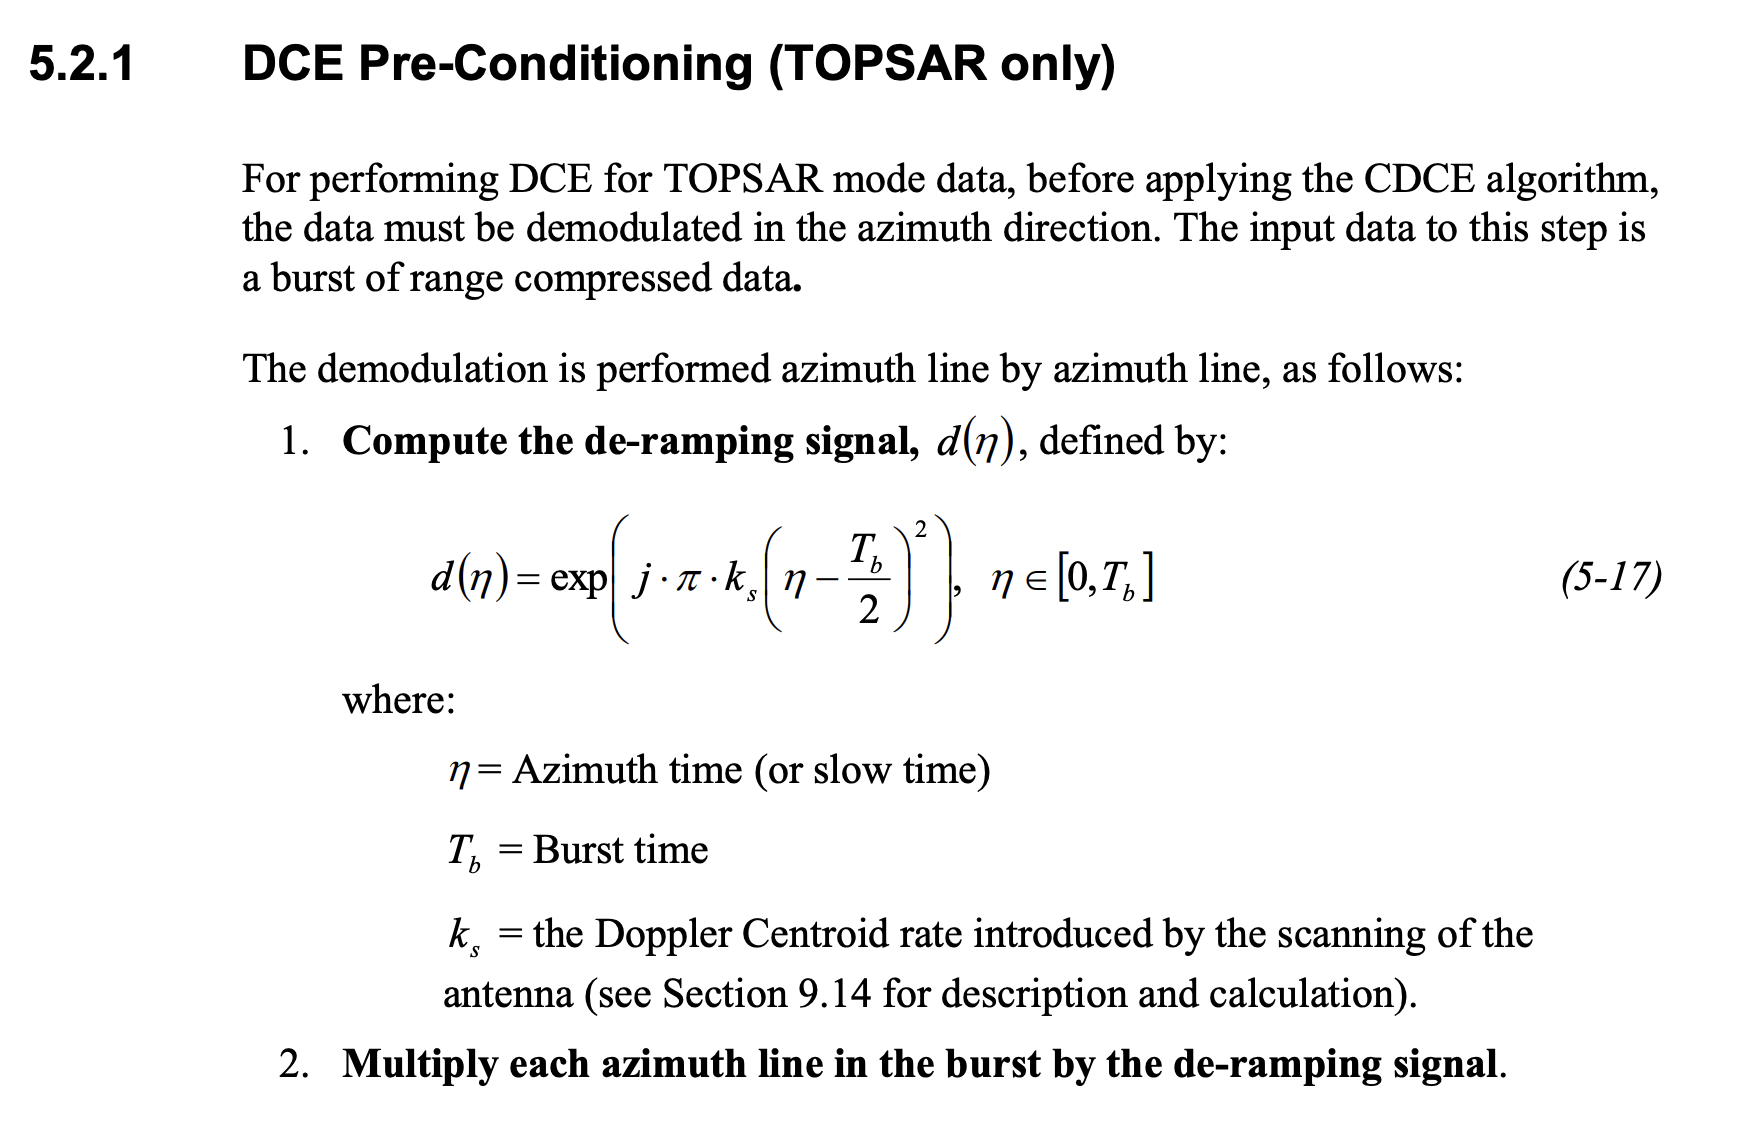

In [525]:
def get_deramping_signal(num_az_samples, doppler_centroid_rate, burst_duration):
    az_time = np.linspace(0, burst_duration, num_az_samples)
    return np.exp(1j * pi * doppler_centroid_rate * (az_time - 0.5*burst_duration)**2)

def dce_preconditioning(range_compressed, doppler_centroid_rate, burst_duration):
    num_az_samples, num_range_samples = range_compressed.shape
    deramping_signal = get_deramping_signal(num_az_samples, doppler_centroid_rate, burst_duration)
    deramped_range_compressed = range_compressed.copy()
    for i in range(num_range_samples):
        deramped_range_compressed[:, i] *= deramping_signal
    return deramped_range_compressed

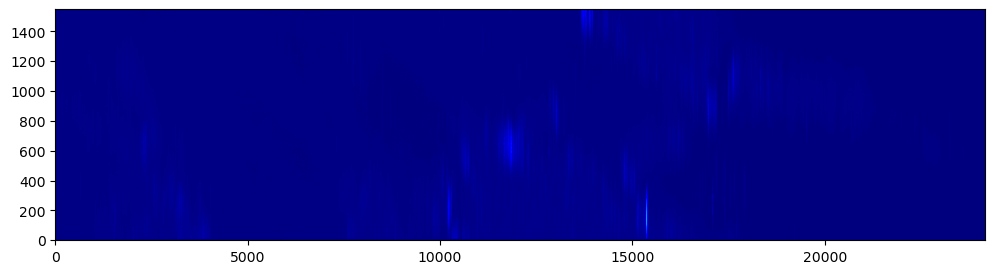

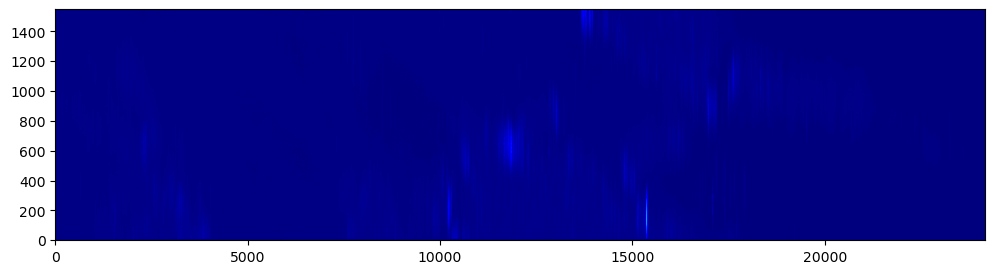

In [526]:
burst_duration_seconds = get_gps_time_from_packet(burst_packets[-1]) - get_gps_time_from_packet(burst_packets[0]) 
deramped_range_compressed = dce_preconditioning(range_compressed_burst, initial_doppler_centroid_rate, burst_duration_seconds)
plot_signals(np.abs(range_compressed_burst) / np.max(np.abs(range_compressed_burst)))
plot_signals(np.abs(deramped_range_compressed) / np.max(np.abs(deramped_range_compressed)))

In [538]:
header = burst_packets[0].get_secondary_header()
fine_dc_estimates_wo_dce_preconditioning = get_fine_dc_estimates(range_compressed_burst, header)
fine_dc_estimates_w_dce_preconditioning = get_fine_dc_estimates(deramped_range_compressed, header)

np.all(range_compressed_burst == deramped_range_compressed), np.all(fine_dc_estimates_w_dce_preconditioning == fine_dc_estimates_wo_dce_preconditioning)

(np.False_, np.True_)

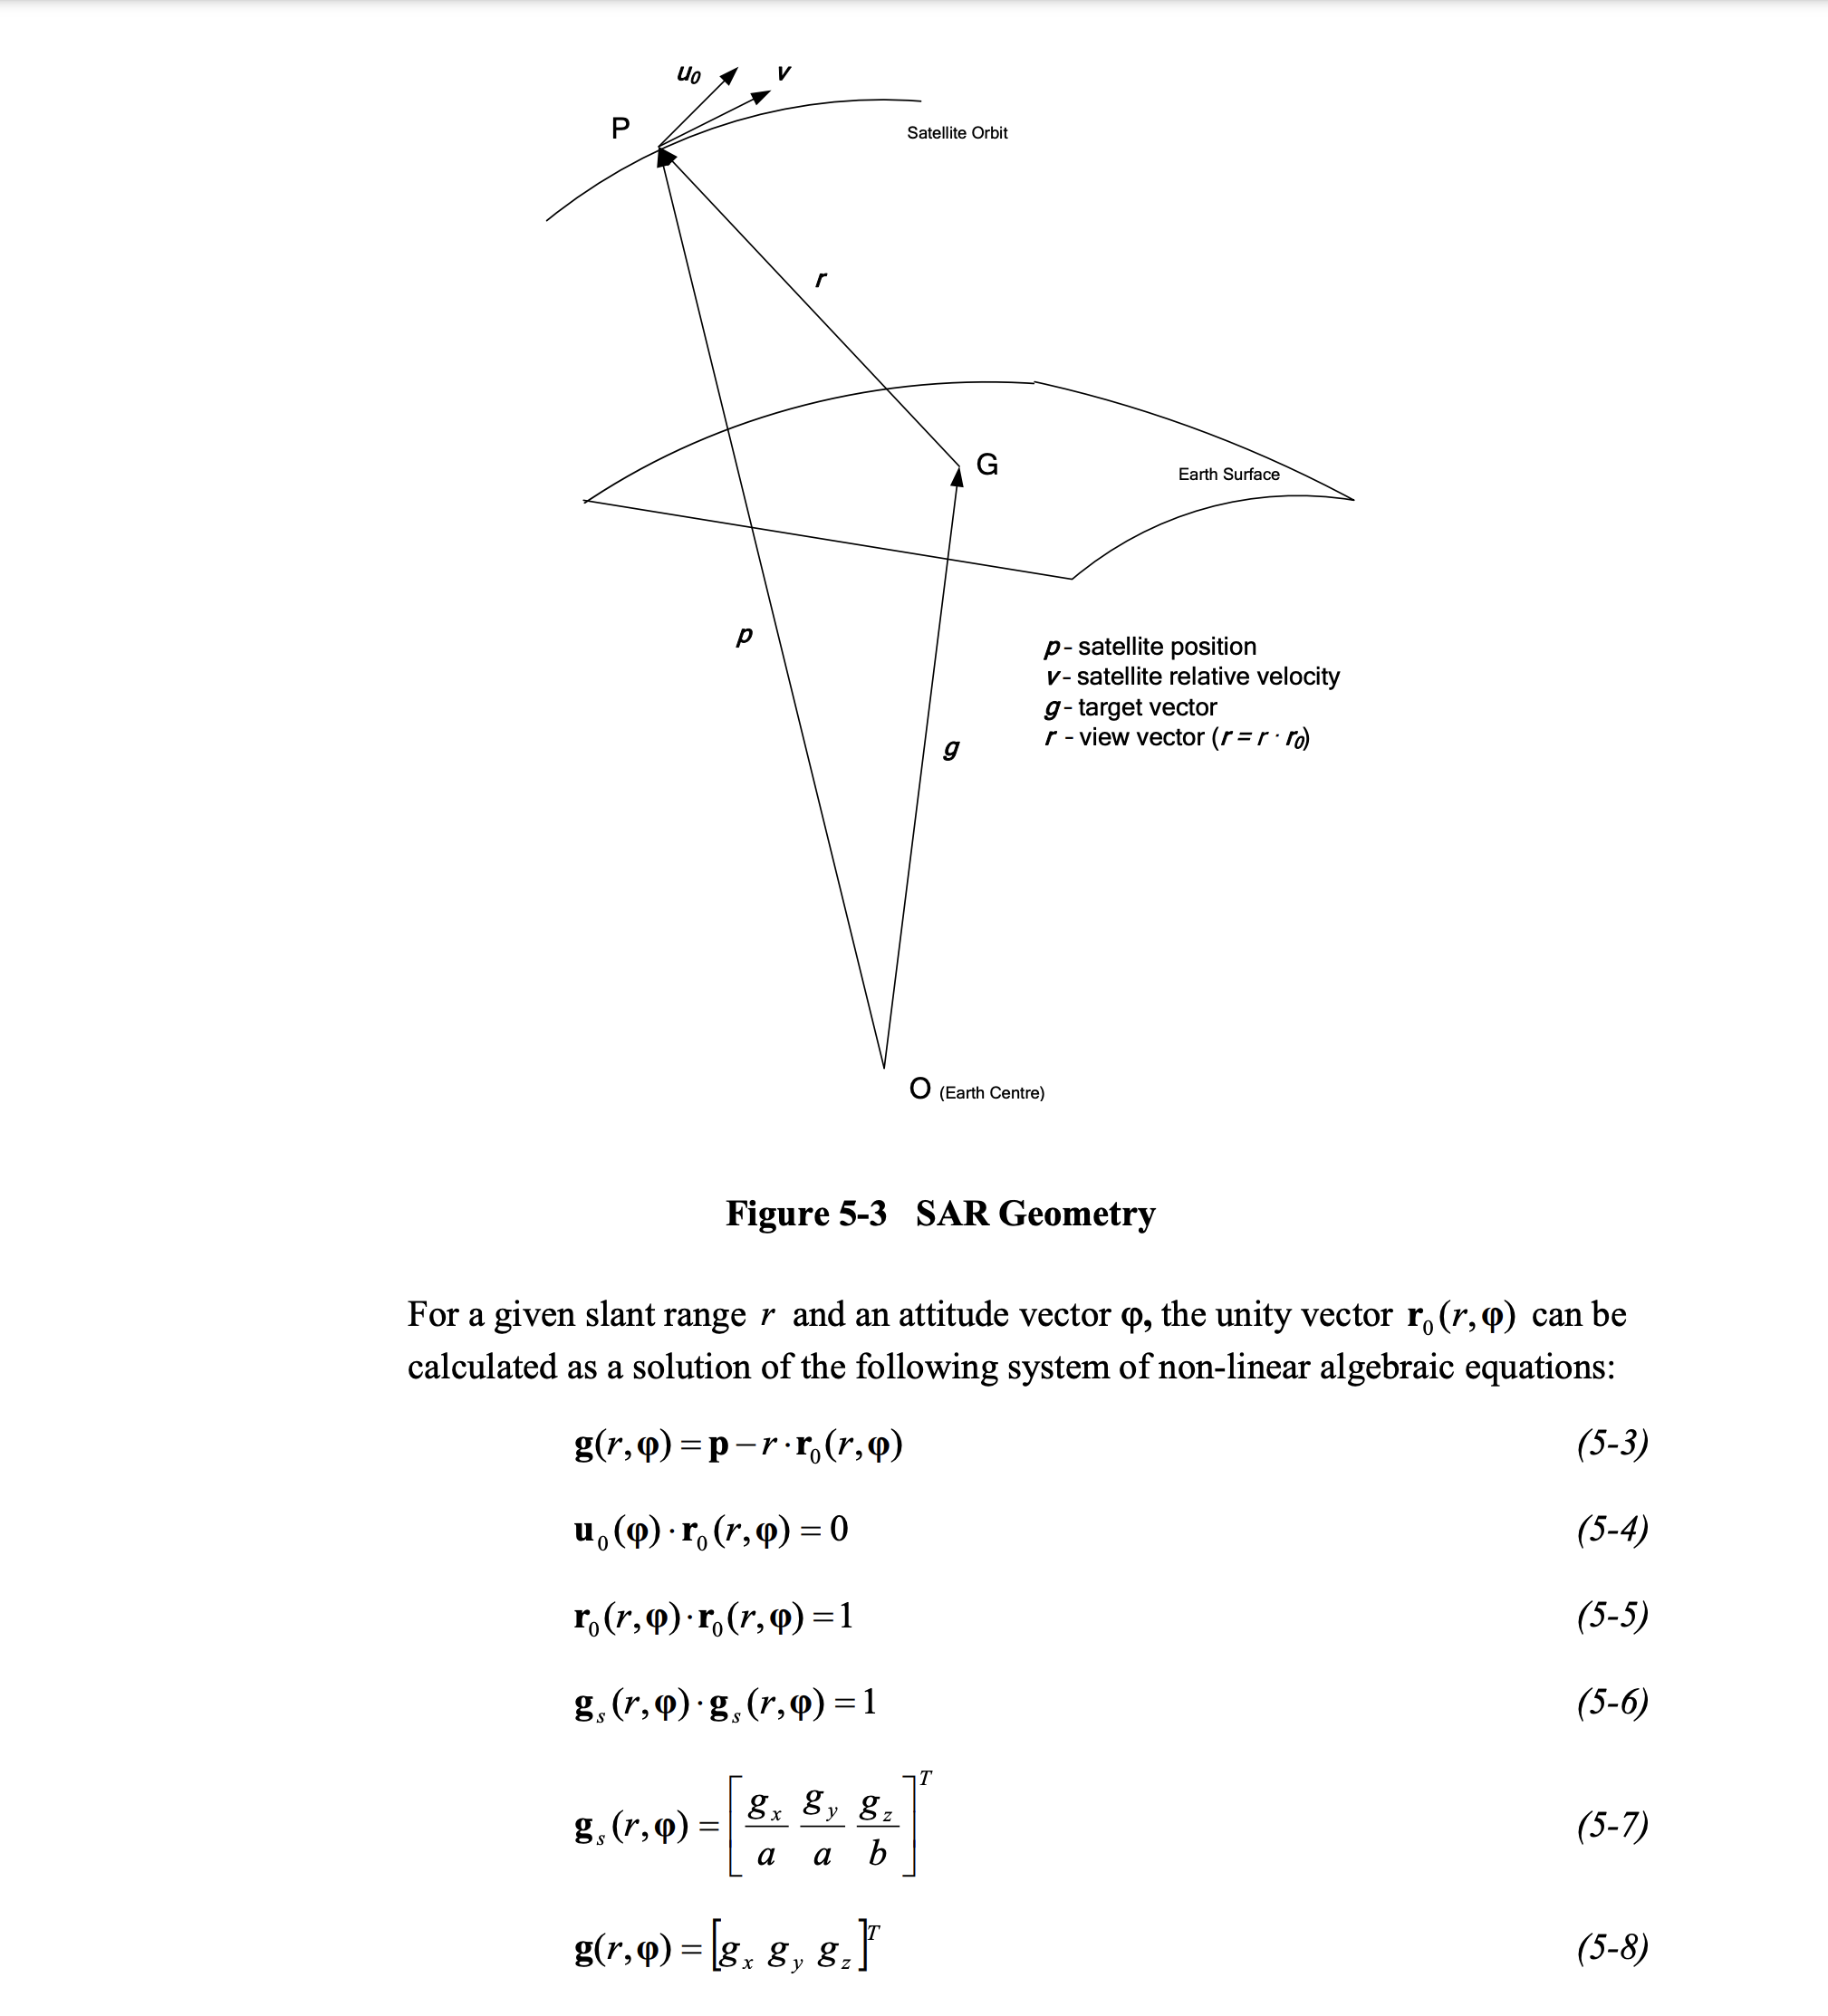
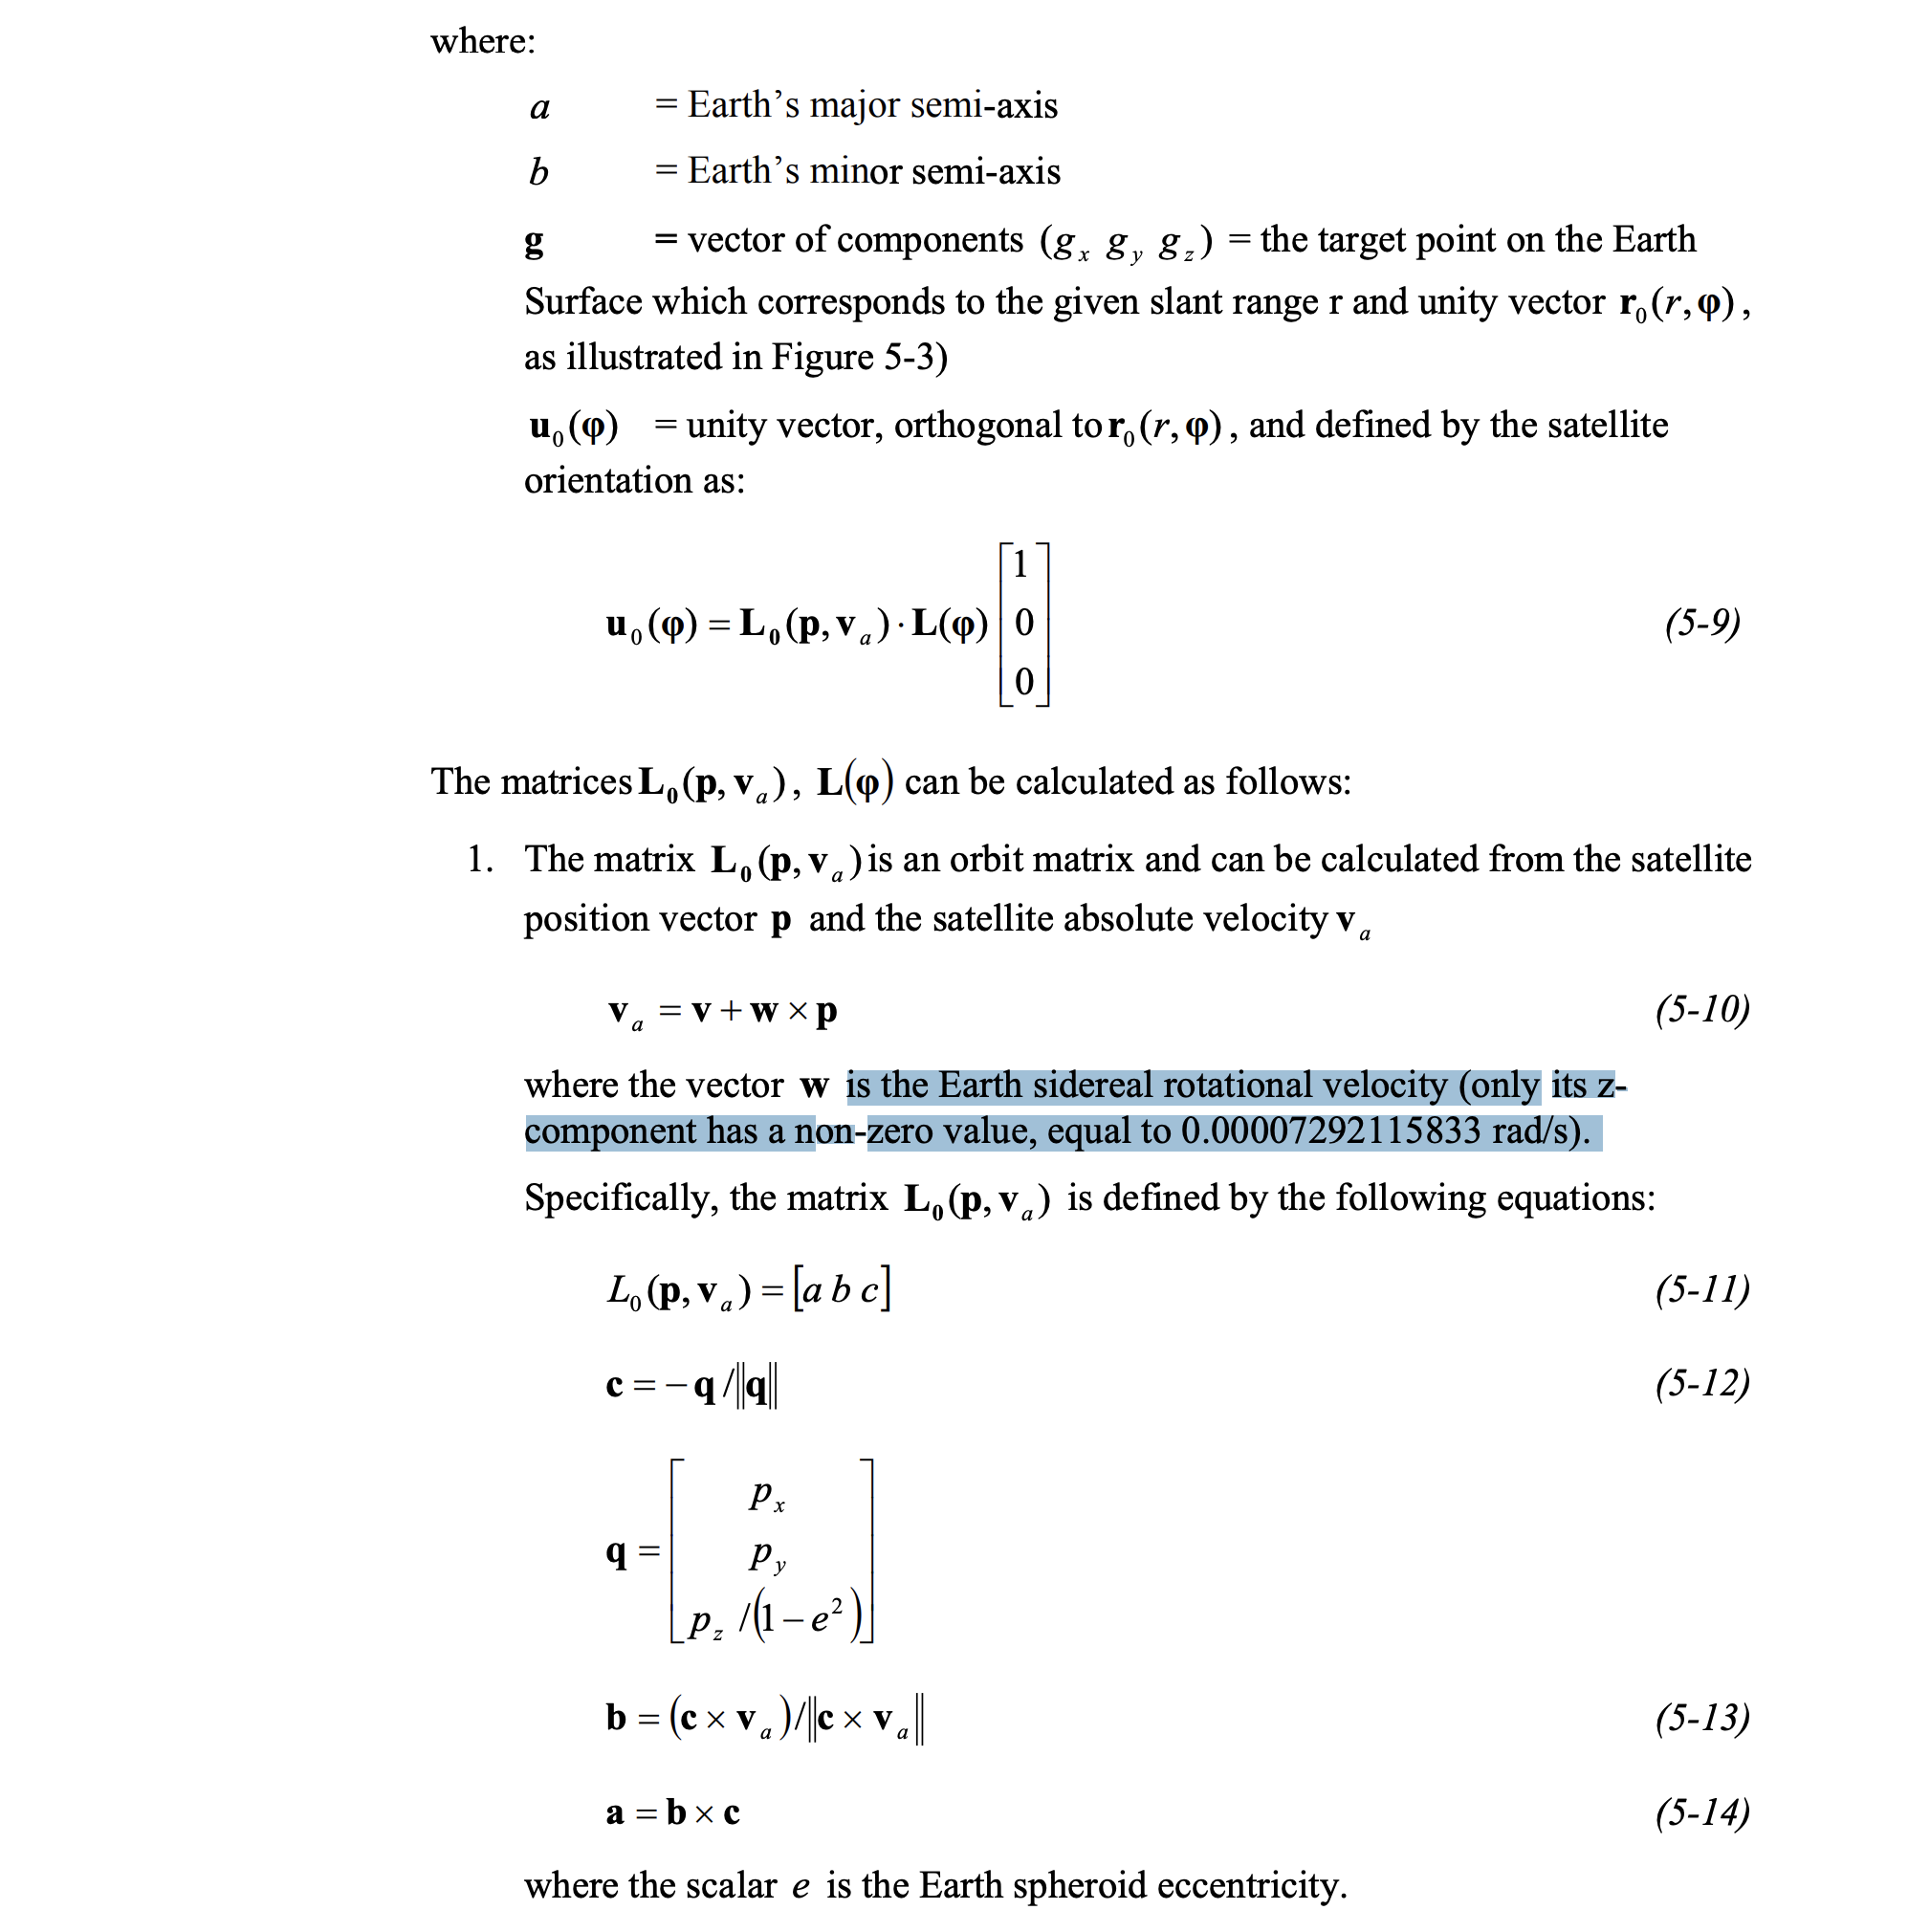
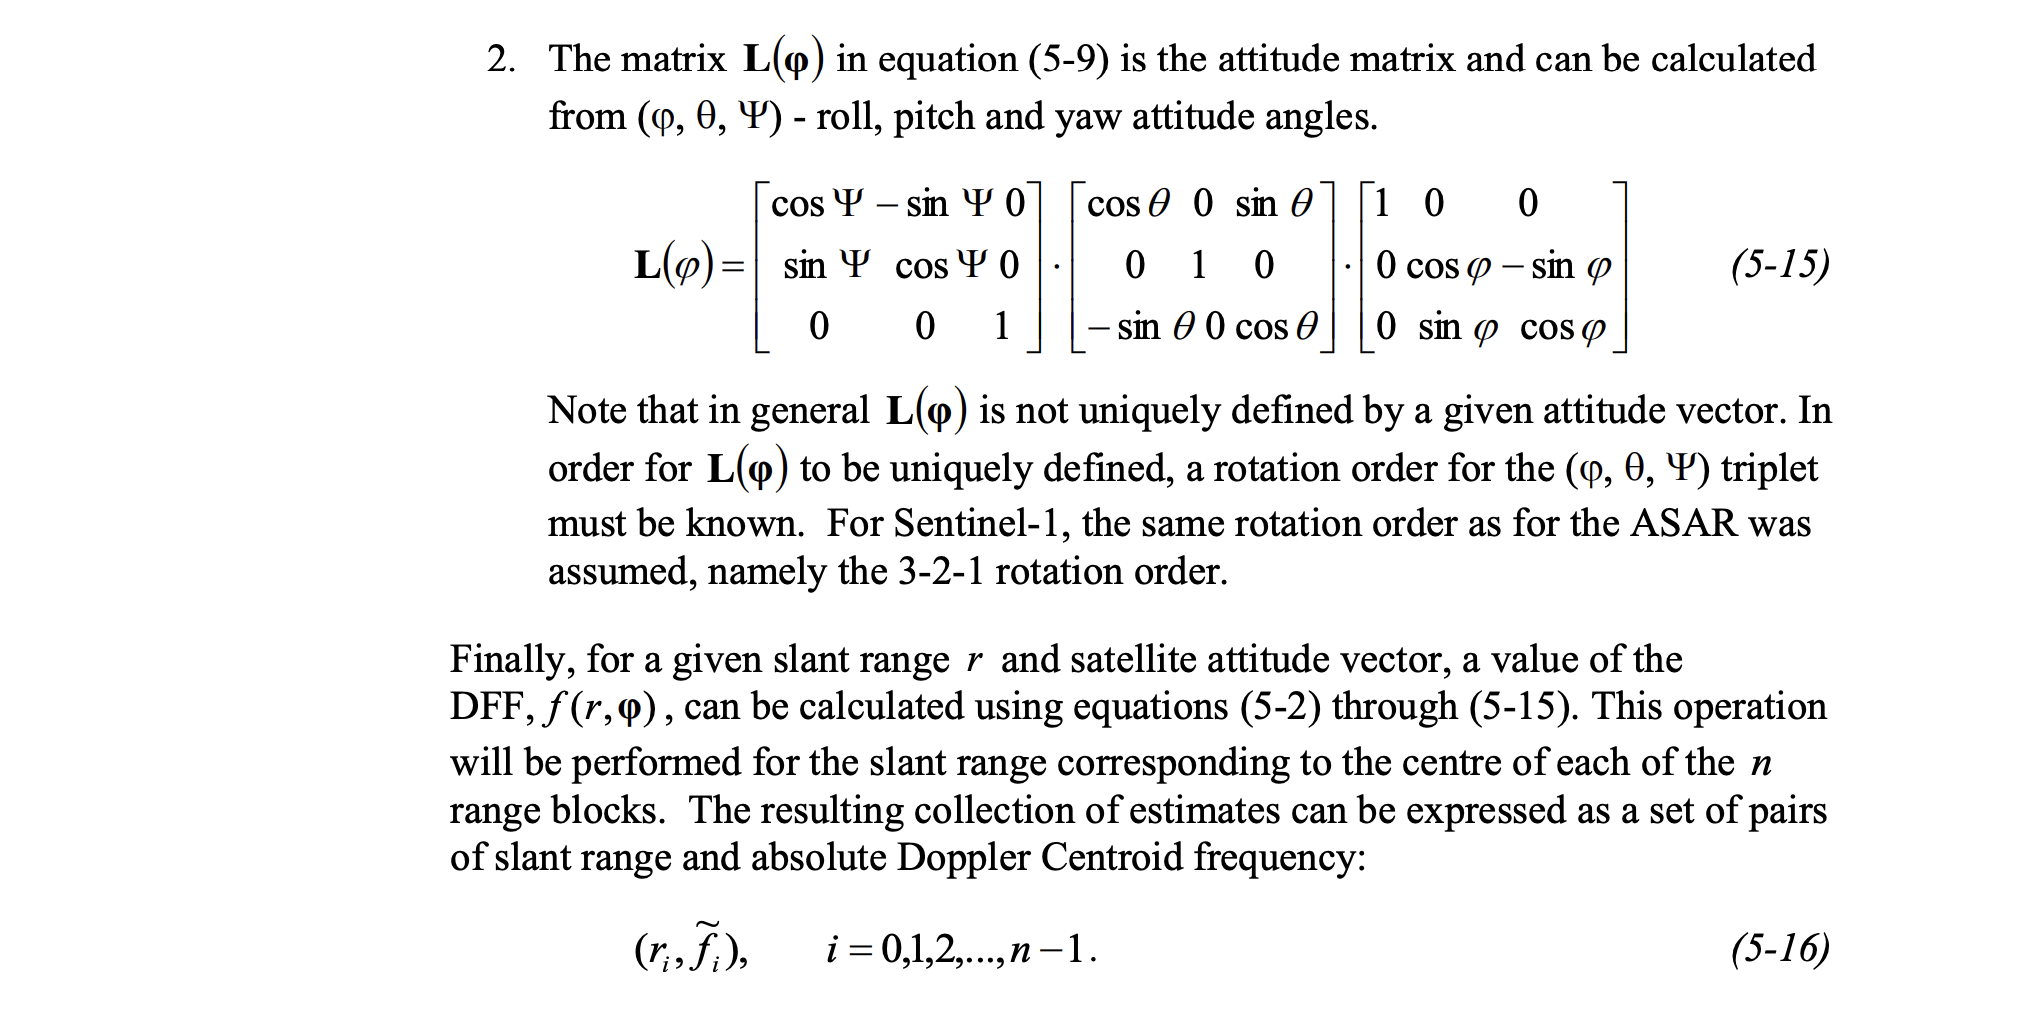

In [201]:
position = state_vectors['position'][0]
velocity = state_vectors['velocity'][0]
quaternions = state_vectors['quaternion'][0]
roll, pitch, yaw = state_vectors['euler_angle'][0]

earth_sidereal = [0, 0, 0.00007292115833]  # rad/s
wgs84_major_a = 6_378_137.0
wgs84_minor_b = 6_356_752.3142
wgs84_eccentricity = 0.0818191908426

In [202]:
v_a = velocity + np.cross(earth_sidereal, position)
q = np.asarray([position[0], position[1], position[2] / (1 - wgs84_eccentricity**2)])
c = -q / np.linalg.norm(q)
b = np.cross(c, v_a) / np.linalg.norm(np.cross(c, v_a))
a = np.cross(b, c)

L_0 = np.asarray([a, b, c])

In [212]:
yaw_rotation = np.asarray([
    [np.cos(yaw), -np.sin(yaw), 0],
    [np.sin(yaw),  np.cos(yaw), 0],
    [0,            0,           1]
])

pitch_rotation = np.asarray([
    [np.cos(pitch),  0, np.sin(pitch)],
    [0,              1,             0],
    [-np.sin(pitch), 0, np.cos(pitch)]
])

roll_rotation = np.asarray([
    [1, 0,                        0],
    [0, np.cos(roll), -np.sin(roll)],
    [0, np.sin(roll),  np.cos(roll)]
])

L_phi = np.dot(roll_rotation, np.dot(pitch_rotation, yaw_rotation))
u_0 = np.dot(L_0, np.matmul(L_phi,np.asarray([1, 0, 0])))

In [335]:
import numpy as np
from scipy.optimize import root, fsolve

# Constants (example values)
a = 6378137.0  # Semi-major axis in meters (WGS84)
b = 6356752.314245  # Semi-minor axis in meters (WGS84)
p = position  # Example vector p
r = (end_range + start_range) / 2  # Example scalar value r
u0 = u_0 

# Function to compute residuals of the equations
def equations(variables):
    # Unpack the variables (gx, gy, gz)
    gx, gy, gz = variables

    # Construct g vector
    g = np.array([gx, gy, gz])

    # Equation 5-6: g_s · g_s = 1
    eq1 = (gx / a)**2 + (gy / a)**2 + (gz / b)**2 - 1

    # Equation derived from 5-4: u_0 · (g - p) = 0
    eq2 = np.dot(u0, g - p)

    # Equation derived from 5-5: (g - p) · (g - p) = r^2
    eq3 = np.dot(g - p, g - p) - r**2

    return [eq1, eq2, eq3]

init_guess = [-2882848, 4674452, 3232495]

# Solve the system of equations
solution = root(equations, init_guess)
r_0 = (-solution.x+p)/r
np.dot(r_0, r_0)

In [360]:
# By law of cosines:
H = np.linalg.norm(position)
Re = wgs84_minor_b
R = r
off_nadir_angle = np.arccos((R**2 + H**2 - Re**2) / (2*R*H))
off_nadir_angle*360/(2*pi)
beta_angle = np.arccos((H**2+Re**2-R**2)/(2*H*Re))
beta_angle*360/(2*pi)
Vg = Re*(velocity/H)*np.cos(beta_angle)
Vr = np.sqrt(np.linalg.norm(velocity)*np.linalg.norm(Vg))
wavelength = 299792458 / 5.404e+9
doppler_frequency = (-2/wavelength) * np.dot(np.sqrt(Vg * velocity), r_0)
np.linalg.norm(doppler_frequency)

In [449]:
burst_length_seconds = get_gps_time_from_packet(burst_packets[-1]) - get_gps_time_from_packet(burst_packets[0]) 

35717.00002002716